# **`word2vec` Training Workflow**
In this workflow, we first train `word2vec` models across years using a range of hyperparameters (e.g., vector dimensions and training epochs). The purpose is twofold: (1) to determine whether models from earlier years are reasonably stable, and (2) choose a set of hyperparameters that yield good results across all years. Models are evaluated using "intrinsic" tests of similarity and analogy performance, which we visualize using plots and analyze using linear regression.

Once we've chosen our hyperparameters, we use them to train models for every year from 1900 through 2019.

## **Setup**
### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from ngramkit.ngram_train.word2vec import build_word2vec_models, evaluate_word2vec_models, plot_evaluation_results
from ngramkit.ngram_train.word2vec import run_regression_analysis, plot_regression_results

### Configure

In [2]:
db_path_stub = '/scratch/edk202/NLP_corpora/Google_Books/'
release = '20200217'
language = 'eng'
size = 5

## **Test Model Hyperparameters**
### Train Models
Here we test models from 1900 tp 2015 in 5-year increments, cycling through a range of reasonable hyperparameters. In this workflow, we constrain our grid search as follows:
1. We stick to the Skip-Gram (`skip-gram`) approach. Skip-gram is known to be more efficient than Continuous Bag of Words (`CBOW`) for Google n-gram data.
2. We test vector dimensions (`vector_size`) from 100 to 300. Our vocabulary is probably too small to support the extraction of more than 300 meaningful features.
3. We test training epochs (`epochs`) from 5 to 30. More than 30 epochs risks overfitting.
4. We set the minimum word count (`min_count`) to 1, meaning that no words will be excluded from training. Our whitelist ensures that all vocabulary words appear frequently in every corpus from 1900 to 2015.
5. Weighting (`weight_by`) is set to none. `word2vec` already downweights extremely frequent words.
6. We set a context window (`window`) of 4. This width extracts as much context as possible from 5-grams.

In [ ]:
build_word2vec_models(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    years=(1900, 2015),
    year_step=5,
    weight_by=('none',),
    vector_size=(100, 200, 300),
    window=(4,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(5, 10, 15, 20, 25, 30),
    max_parallel_models=25,
    workers_per_model=4,
    mode="resume",
    unk_mode="retain",
    use_corpus_file=True,
    cache_corpus=True
);


Scanning for existing models...


Scanning existing models: 100%|██████████| 258/258 [00:02<00:00, 103.45 files/s]

  Valid models found:    258
  Invalid/partial:       0

WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-18 16:49:02

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             .../edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/5grams_pivoted.db
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Log directory:        .../edk202/NLP_models/Google_Books/20200217/eng/5gram_files/logs_test/training
Parallel models:      25

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2015 (step=5, 24 years)
Weighting:            ('none',)
Vector size:          (100, 200, 300)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training e

### Evaluate Models

Here we evaluate the models we've trained using two "intrinsic" tests: (1) a _similarity test_ assessing how well each model predicts human-rated synonymy judgments, and (2) an _analogy test_ assessing how well each model can answer SAT-style analogy questions. Test results are saved to a CSV file.

Similarity performance is the metric of choice for models intended to track semantic relatedness over time. However, we run both tests here to demonstrate the evaluation code and show that different hyperparameters lend themselves to different performance metrics.

In [ ]:
evaluate_word2vec_models(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    save_mode='overwrite',
    run_similarity=True,
    run_analogy=True,
    workers=100
)


WORD2VEC MODEL EVALUATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-17 10:06:06

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      ...edk202/NLP_models/Google_Books/20200217/eng-fiction/5gram_files/models_test
Evaluation file:      ...s/Google_Books/20200217/eng-fiction/5gram_files/evaluation_results_test.csv
Log directory:        ...P_models/Google_Books/20200217/eng-fiction/5gram_files/logs_test/evaluation
Save mode:            overwrite

Evaluation Datasets
────────────────────────────────────────────────────────────────────────────────────────────────────
Similarity dataset:   ...miniforge/lib/python3.11/site-packages/gensim/test/test_data/wordsim353.tsv
Analogy dataset:      ...orge/lib/python3.11/site-packages/gensim/test/test_data/questions-words.txt

Found 432 models to evaluate



Evaluating models:   0%|          | 0/432 [00:00<?, ? models/s]

### Visualize Model Performance
The code below plots the results of the similarity and analogy tests for easy inspection.
#### Similarity Results

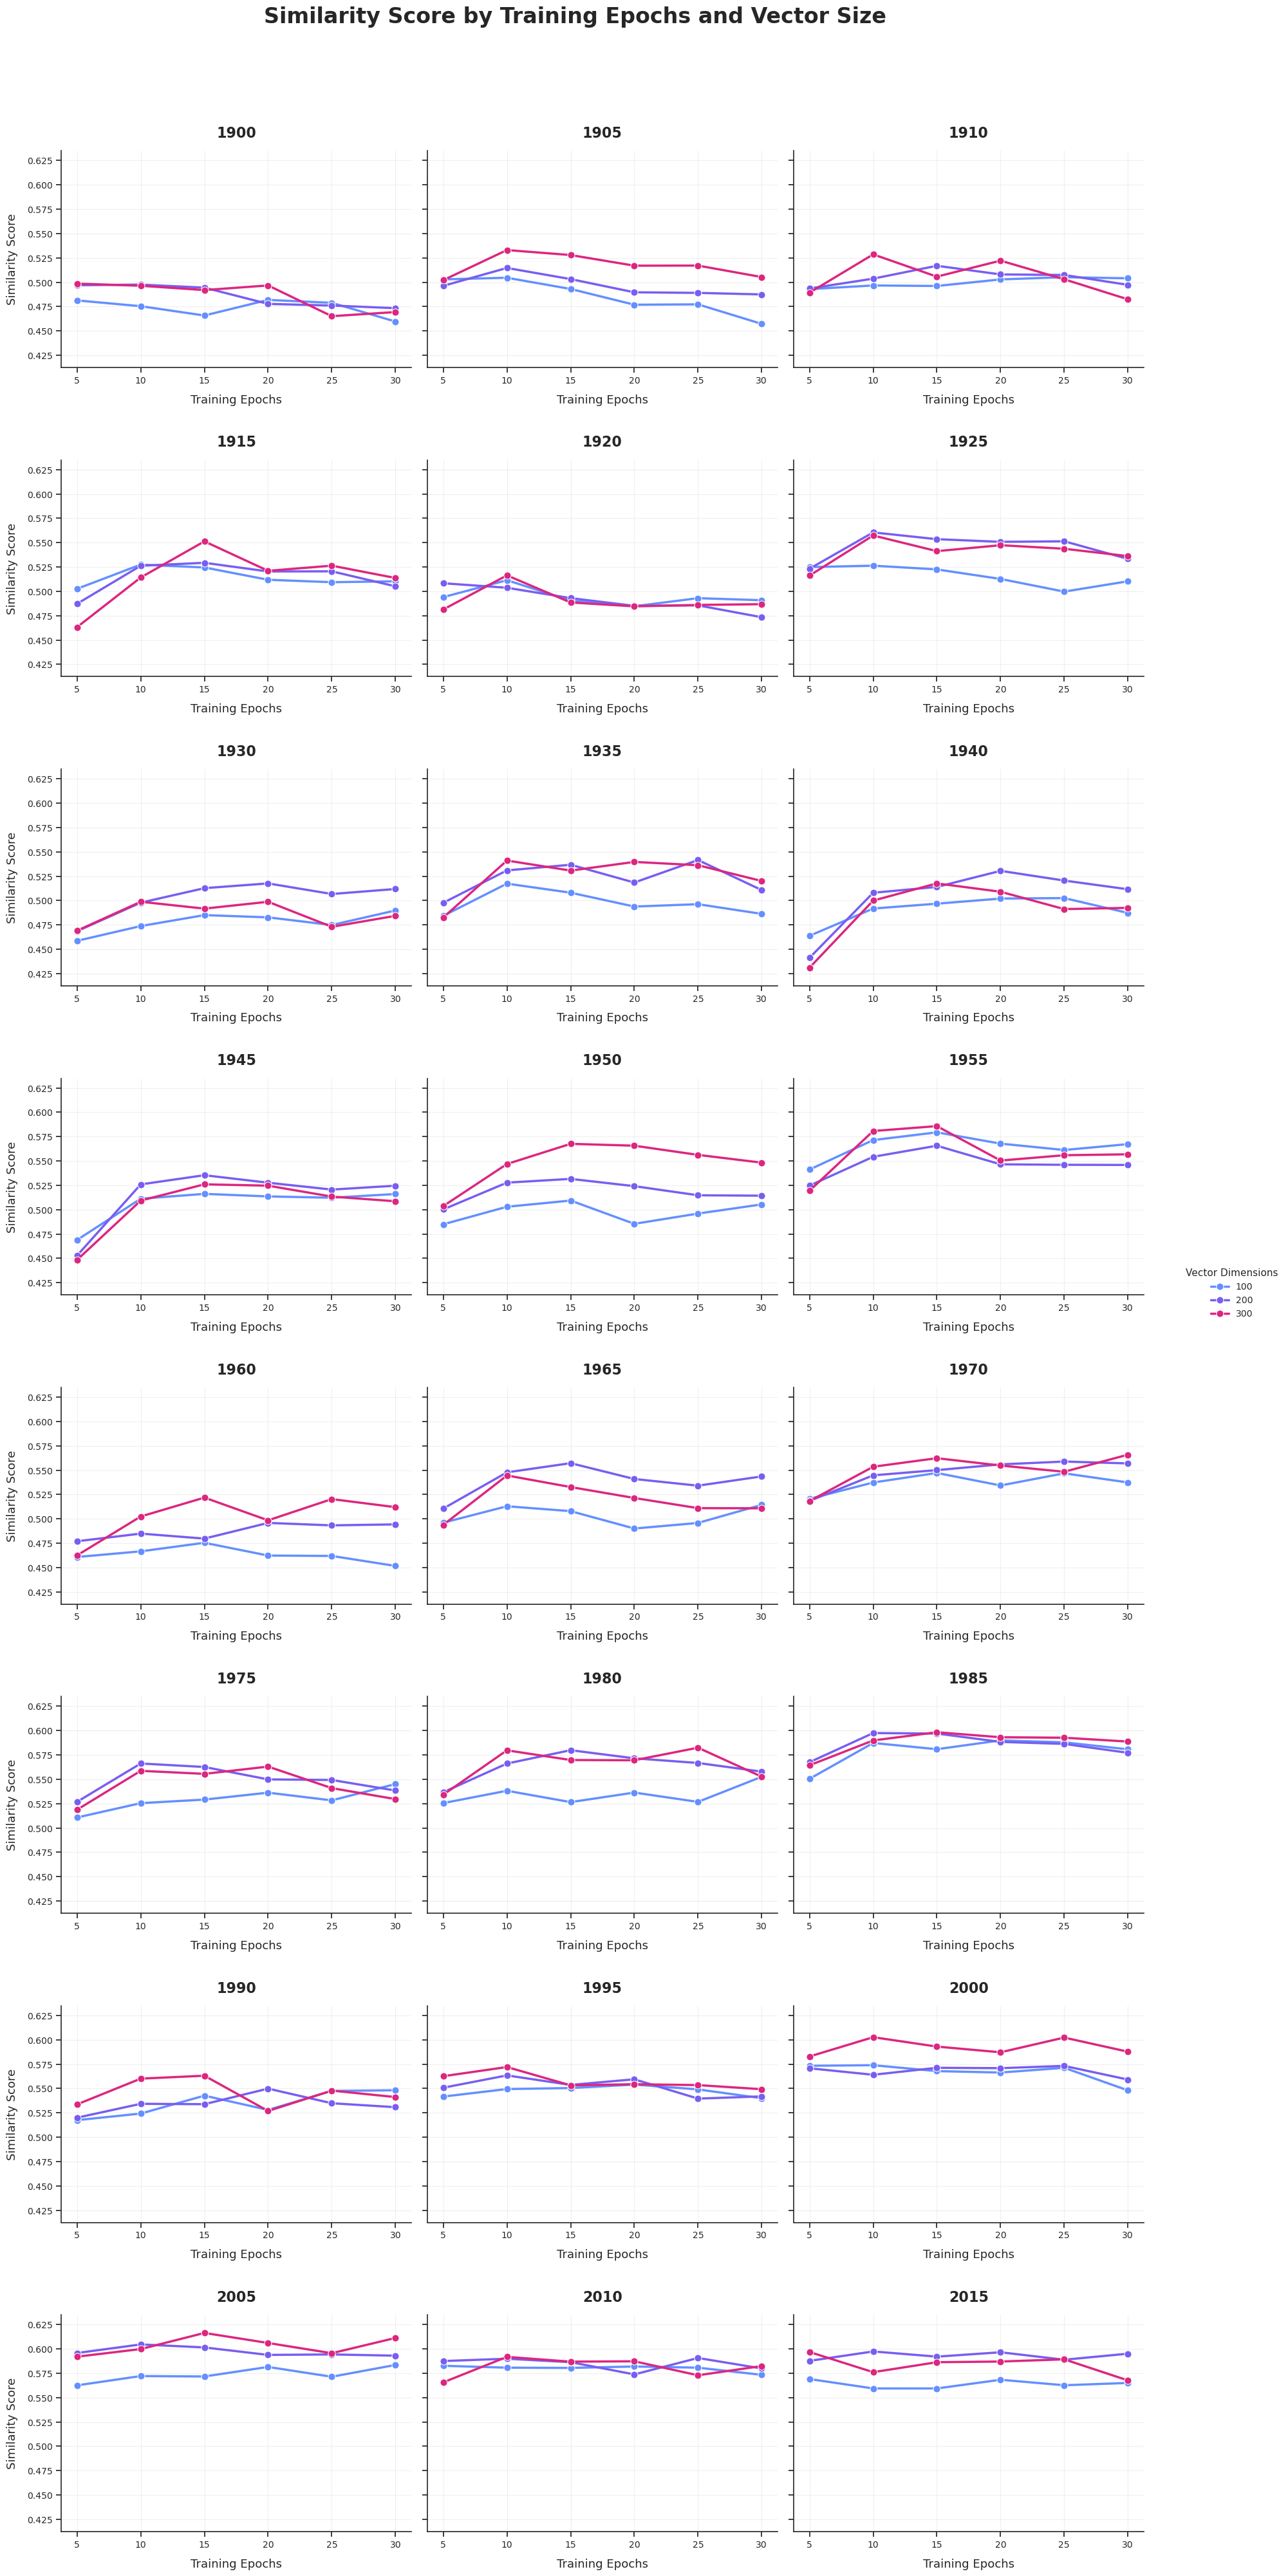

In [3]:
plot_evaluation_results(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    verbose=False,
    metric='similarity_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Similarity Score by Training Epochs and Vector Size'
)

#### Analogy Results

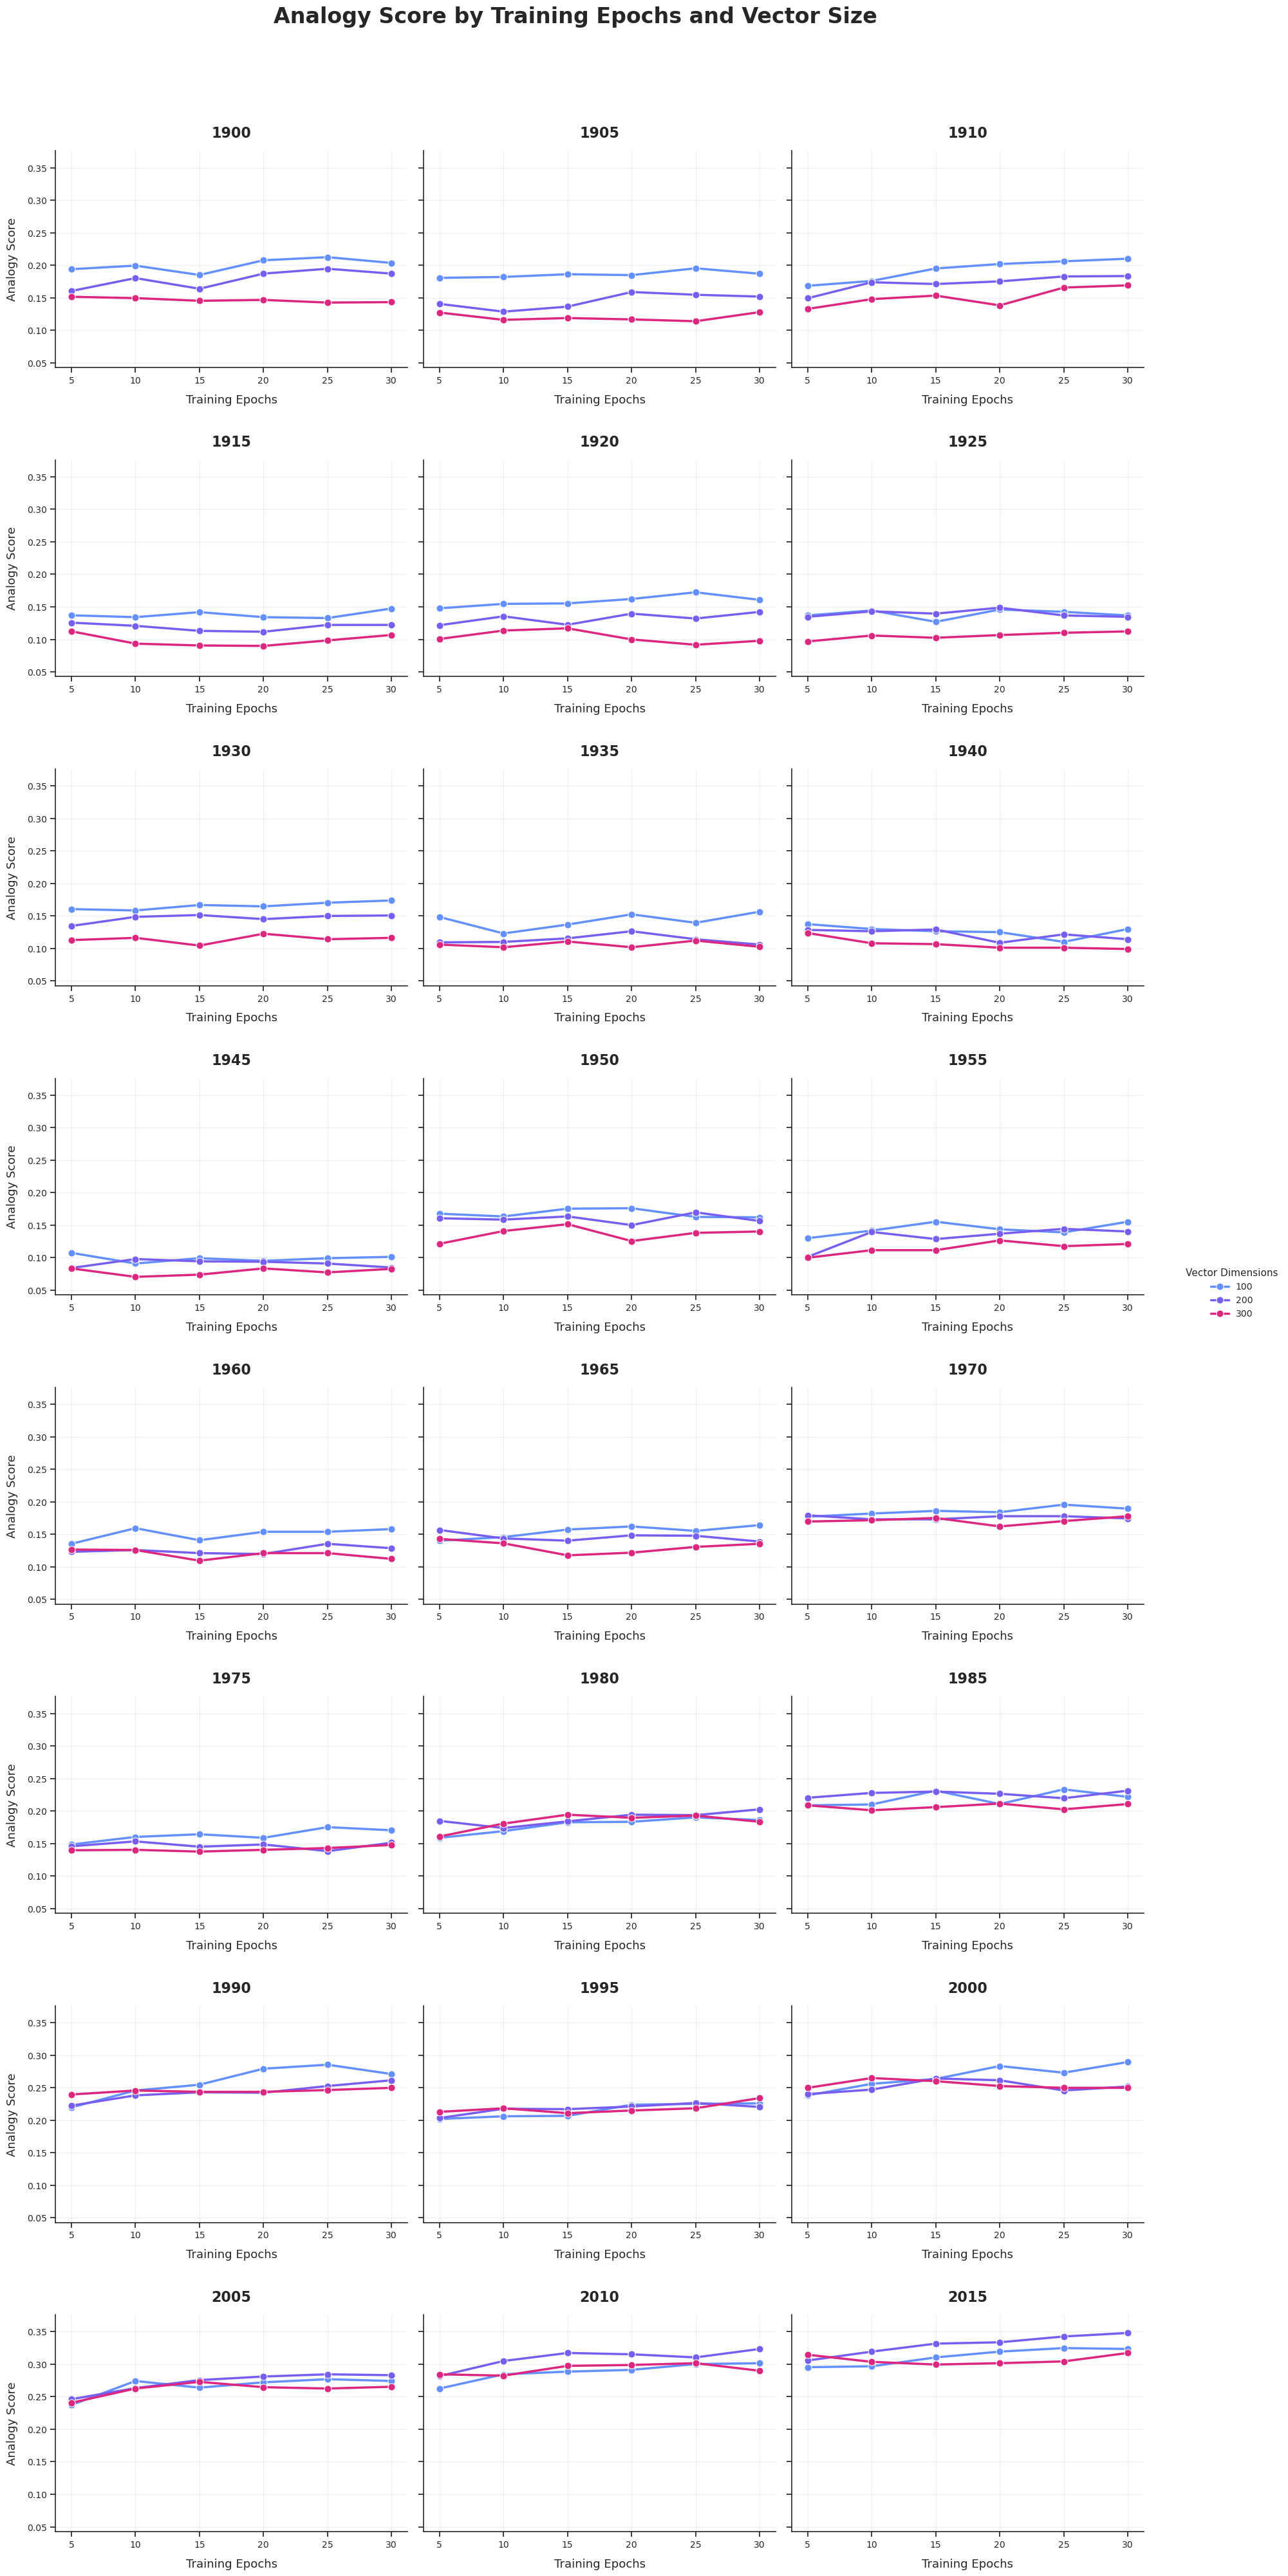

In [4]:
plot_evaluation_results(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    verbose=False,
    metric='analogy_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Analogy Score by Training Epochs and Vector Size'
)

### Regression Analysis
The code below runs regression analyses on the similarity and analogy results.
#### Predictors of Similarity Performance

Loading data...
Loaded 432 observations
Number of years: 24

Model specification:
  Formula: similarity_score ~ scale(year) + scale(vector_size) + scale(epochs) + C(approach) + scale(year):scale(vector_size) + scale(year):scale(epochs) + scale(vector_size):scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Model converged successfully!

                   Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     similarity_score
No. Observations:      432         Method:                 REML            
No. Groups:            24          Scale:                  0.0003          
Min. group size:       18          Log-Likelihood:         1093.6144       
Max. group size:       18          Converged:              Yes             
Mean group size:       18.0                                                
---------------------------------------------------------------------------
                                 Coef. Std.Err.    z  

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


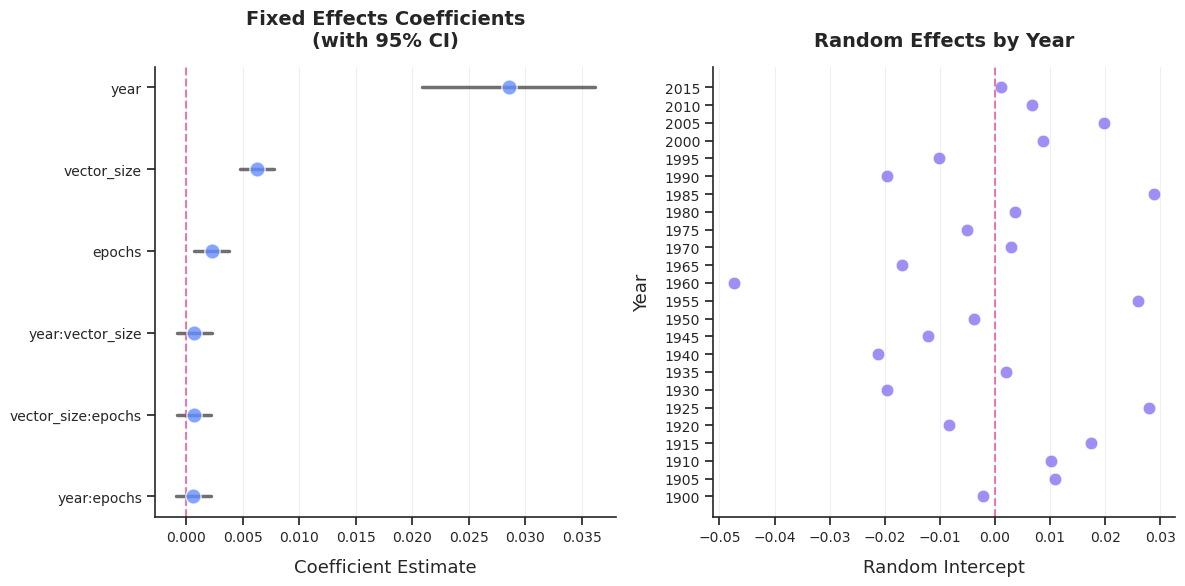

In [5]:
results = run_regression_analysis(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    model_type="auto",
    outcome='similarity_score',
    predictors=['year', 'vector_size', 'epochs', 'approach'],
    interactions=[('year', 'vector_size'), ('year', 'epochs'), ('vector_size', 'epochs')],
)

plot_regression_results(results)

#### Predictors of Analogy Performance

Loading data...
Loaded 432 observations
Number of years: 24

Model specification:
  Formula: analogy_score ~ scale(year) + scale(vector_size) + scale(epochs) + C(approach) + scale(year):scale(vector_size) + scale(year):scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Model converged successfully!

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      analogy_score
No. Observations:      432          Method:                  REML         
No. Groups:            24           Scale:                   0.0001       
Min. group size:       18           Log-Likelihood:          1275.9786    
Max. group size:       18           Converged:               Yes          
Mean group size:       18.0                                               
--------------------------------------------------------------------------
                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------

/opt/miniforge/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


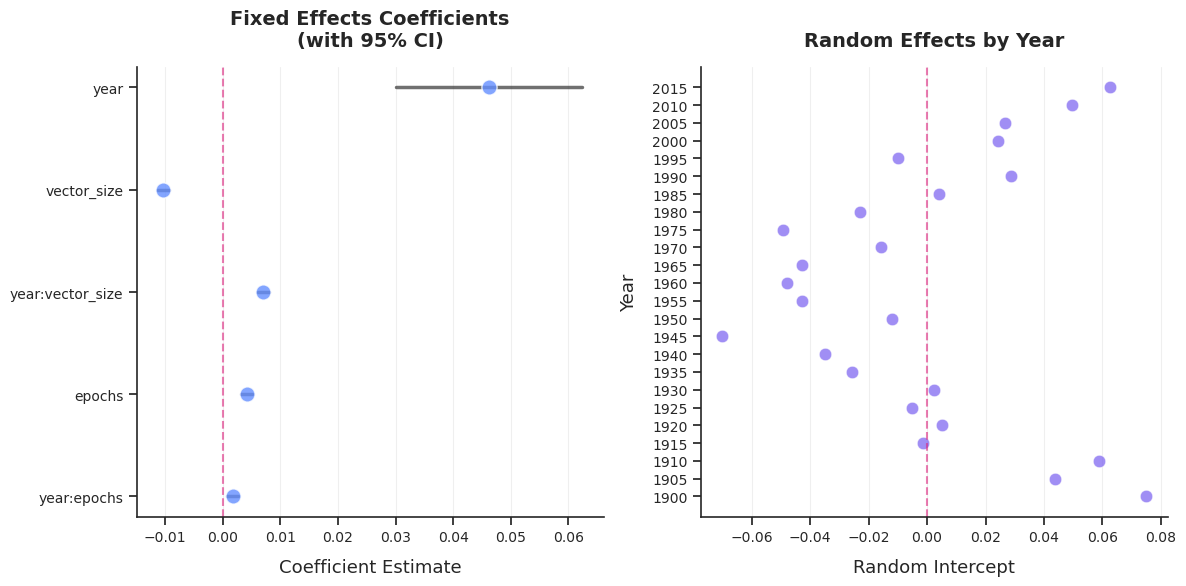

In [8]:
results = run_regression_analysis(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    model_type="auto",
    outcome='analogy_score',
    predictors=['year', 'vector_size', 'epochs', 'approach'],
    interactions=[('year', 'vector_size'), ('year', 'epochs')],
)

plot_regression_results(results)

## **Train Final Models**

Having explored a range of hyperparameters, we train final models for every year from 1900 through 2019 using what we've learned. A defensible hyperparameter set is:
1. `approach=('skip-gram',)`
2. `window=(4,)`
3. `vector_size=(200,)`
4. `epochs=(10,)`
5. `min_count=1`

In [4]:
build_word2vec_models(
    ngram_size=size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='final',
    years=(1900, 2019),
    year_step=1,
    weight_by=('none',),
    vector_size=(200,),
    window=(4,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(10,),
    max_parallel_models=20,
    workers_per_model=3,
    mode="resume",
    unk_mode="strip",
    use_corpus_file=True
);


Scanning for existing models...


Scanning existing models: 100%|██████████| 120/120 [00:01<00:00, 113.02 files/s]

  Valid models found:    120
  Invalid/partial:       0

WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-11-17 13:21:43

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             ...NLP_corpora/Google_Books/20200217/eng-fiction/5gram_files/5grams_pivoted.db
Model directory:      ...dk202/NLP_models/Google_Books/20200217/eng-fiction/5gram_files/models_final
Log directory:        ...LP_models/Google_Books/20200217/eng-fiction/5gram_files/logs_final/training
Parallel models:      20

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2019 (120 years)
Weighting:            ('none',)
Vector size:          (200,)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training epochs:      (1

Execution
────────────────────────────────────────────────────────────────────────────────────────────────────
Total models in grid: 120
Existing valid:       120
Models to train:      0
Parameter combos:     1
Years:                120



Training Models: 0 models [00:00, ? models/s]


Training Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models trained:       0
Model directory:      ...dk202/NLP_models/Google_Books/20200217/eng-fiction/5gram_files/models_final
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



## **Normalize and Align Models**

Before we can use the models for diachronic analysis, we need to unit-normalize the vectors and align them across years using Procrustes rotation. The `normalize_and_align_vectors` function does this.

In [6]:
from ngramkit.ngram_train.word2vec.normalize_and_align_models import normalize_and_align_vectors

ngram_size = 5
proj_dir = f'/scratch/edk202/NLP_models/Google_Books/{release}/{language}'
dir_suffix = 'final'
anchor_year = 2019
workers = 32

normalize_and_align_vectors(
    ngram_size=ngram_size,
    proj_dir=proj_dir,
    dir_suffix=dir_suffix,
    anchor_year=anchor_year,
    workers=workers
)

Saved normalized anchor model to /scratch/edk202/NLP_models/Google_Books/20200217/eng-fiction/5gram_files/models_final/norm_and_align/w2v_y2019_wbnone_vs200_w004_mc001_sg1_e010.kv


Processing models: 100%|██████████| 119/119 [01:36<00:00,  1.23file/s]


Total runtime: 0:01:37.244103
Processed 120 models. Aligned to anchor year 2019.
